In [12]:
  !pip3 install --upgrade pip
  !pip3 install tensorflow==2.15.0

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfull

In [11]:
!pip uninstall tensorflow-quantum
!pip install tensorflow-quantum

Found existing installation: tensorflow-quantum 0.7.3
Uninstalling tensorflow-quantum-0.7.3:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/tensorflow_quantum-0.7.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow_quantum/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-quantum-0.7.3
  Using cached tensorflow_quantum-0.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.7 kB)
Using cached tensorflow_quantum-0.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.8 MB)


In [1]:
import cirq
import tensorflow_quantum as tfq
import sympy

def create_quantum_circuit(qubits):
    circuit = cirq.Circuit()
    for qubit in qubits:
        circuit.append(cirq.rx(sympy.Symbol(f'rx_{qubit}')).on(qubit))
        circuit.append(cirq.rz(sympy.Symbol(f'rz_{qubit}')).on(qubit))
    return circuit

In [2]:
import tensorflow as tf

def create_quantum_model(qubits):
    circuit = create_quantum_circuit(qubits)
    inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)
    quantum_layer = tfq.layers.PQC(circuit, cirq.Z(qubits[0]))(inputs)
    return tf.keras.Model(inputs=inputs, outputs=quantum_layer)

In [3]:
from tensorflow.keras import layers, models

def create_classical_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    return model

In [4]:
import numpy as np
import tensorflow as tf
import cirq

def preprocess_images_py(images):
    images = tf.image.resize(images, (1, len(qubits)))
    images = tf.reshape(images, (-1, len(qubits))).numpy()
    circuits = [cirq.Circuit(cirq.X(qubits[j]) for j in range(len(qubits)) if pixel[j] > 0.5) for pixel in images]
    return tfq.convert_to_tensor(circuits)

def preprocess_images(images):
    return tf.py_function(func=preprocess_images_py, inp=[images], Tout=tf.dtypes.string)

In [5]:
def create_hybrid_model(quantum_model, classical_model):
    classical_input = tf.keras.layers.Input(shape=(28, 28, 1))
    preprocessed_images = tf.keras.layers.Lambda(preprocess_images)(classical_input)
    quantum_output = quantum_model(preprocessed_images)
    classical_output = classical_model(classical_input)
    outputs = tf.keras.layers.concatenate([quantum_output, classical_output])
    outputs = tf.keras.layers.Dense(10, activation='softmax')(outputs)
    return tf.keras.Model(inputs=classical_input, outputs=outputs)

In [6]:
# Verilerinizi yükleyin
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[..., tf.newaxis] / 255.0
x_test = x_test[..., tf.newaxis] / 255.0

# Modelleri oluşturun
n_qubits = 4
qubits = [cirq.GridQubit(0, i) for i in range(n_qubits)]
quantum_model = create_quantum_model(qubits)
classical_model = create_classical_model()
hybrid_model = create_hybrid_model(quantum_model, classical_model)

# Modeli derleyin ve eğitin
hybrid_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
hybrid_model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Test edin
test_loss, test_acc = hybrid_model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1688/1688 [==============================] - 153s 89ms/step - loss: 0.1569 - accuracy: 0.9517 - val_loss: 0.0523 - val_accuracy: 0.9870
Epoch 2/5
1688/1688 [==============================] - 149s 88ms/step - loss: 0.0497 - accuracy: 0.9847 - val_loss: 0.0507 - val_accuracy: 0.9855
Epoch 3/5
1688/1688 [==============================] - 160s 95ms/step - loss: 0.0340 - accuracy: 0.9892 - val_loss: 0.0351 - val_accuracy: 0.9912
Epoch 4/5
1688/1688 [==============================] - 146s 86ms/step - loss: 0.0264 - accuracy: 0.9914 - val_loss: 0.0361 - val_accuracy: 0.9902
Epoch 5/5
1688/1688 [==============================] - 141s 83ms/step - loss: 0.0196 - accuracy: 0.9931 - val_loss: 0.0359 - val_accuracy: 0.9897
313/313 - 12s - loss: 0.0303 - accuracy: 0.9914 - 12s/epoch - 38ms/step
Test accuracy: 0.9914000034332275


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image(image, label, prediction=None):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'True Label: {label}' + (f', Predicted: {prediction}' if prediction is not None else ''))
    plt.axis('off')
    plt.show()

def plot_predictions(x_test, y_test, predictions, num_examples=10):
    indices = np.random.choice(len(x_test), num_examples, replace=False)
    for i in indices:
        plt.figure(figsize=(5, 5))
        plot_image(x_test[i], y_test[i], predictions[i])


313/313 [==============================] - 17s 53ms/step


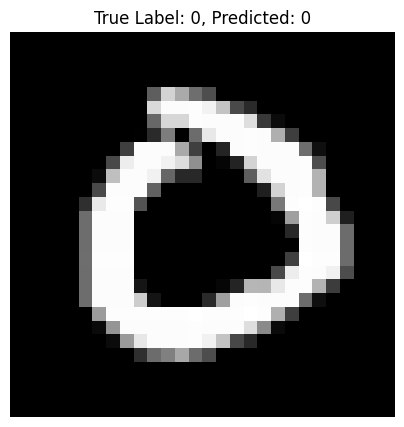

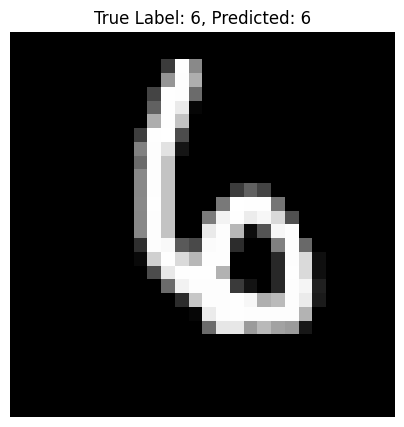

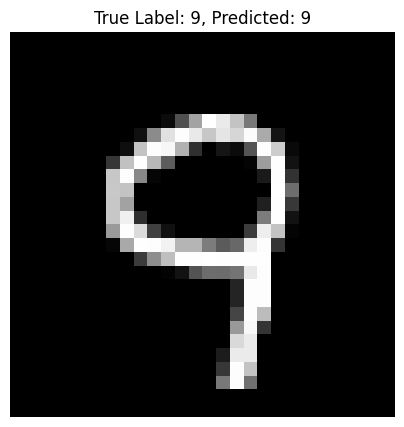

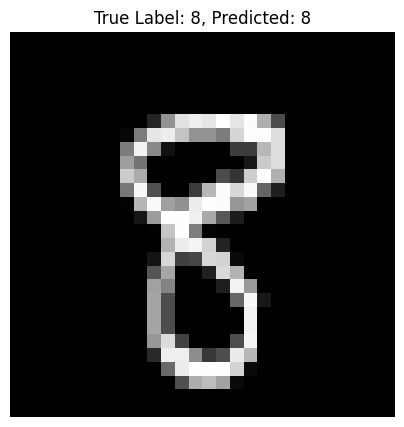

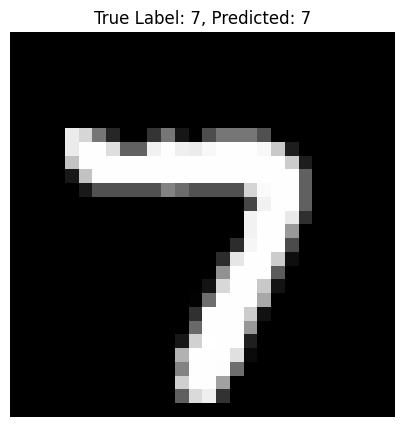

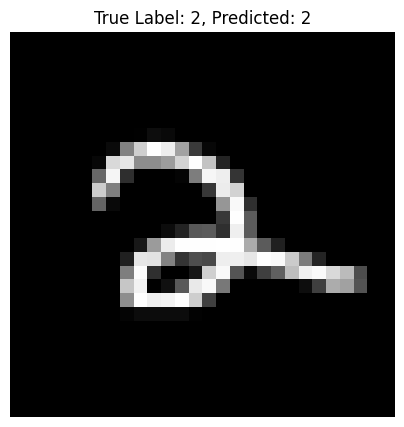

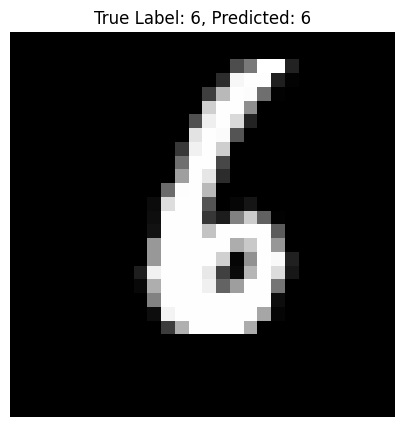

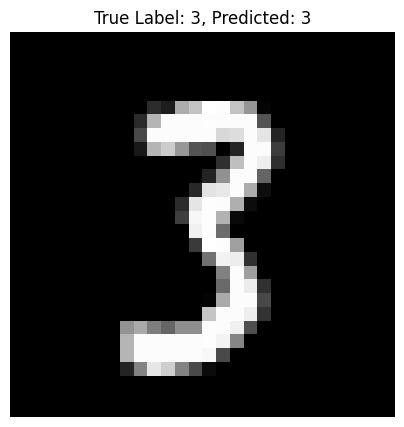

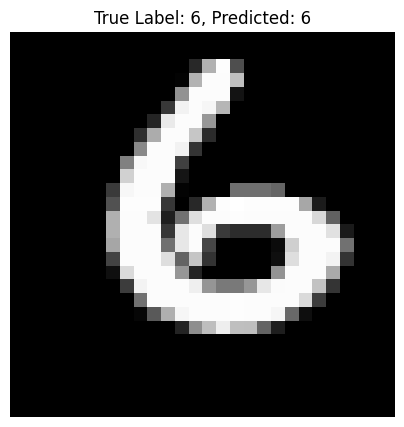

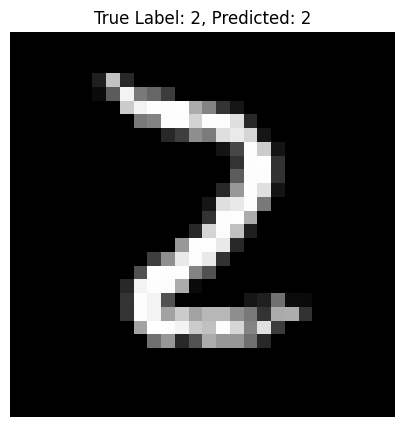

In [11]:
# Test verileri ile tahmin yapma
test_predictions = hybrid_model.predict(x_test)
predicted_labels = np.argmax(test_predictions, axis=1)

# İlk birkaç görüntü ve tahmin sonuçlarını görselleştirin
plot_predictions(x_test, y_test, predicted_labels, num_examples=10)


Epoch 1/5
1688/1688 [==============================] - 153s 91ms/step - loss: 0.0158 - accuracy: 0.9947 - val_loss: 0.0353 - val_accuracy: 0.9905
Epoch 2/5
1688/1688 [==============================] - 149s 89ms/step - loss: 0.0146 - accuracy: 0.9952 - val_loss: 0.0341 - val_accuracy: 0.9915
Epoch 3/5
1688/1688 [==============================] - 148s 88ms/step - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.0360 - val_accuracy: 0.9917
Epoch 4/5
1688/1688 [==============================] - 148s 88ms/step - loss: 0.0094 - accuracy: 0.9970 - val_loss: 0.0456 - val_accuracy: 0.9908
Epoch 5/5
1688/1688 [==============================] - 150s 89ms/step - loss: 0.0085 - accuracy: 0.9971 - val_loss: 0.0346 - val_accuracy: 0.9925


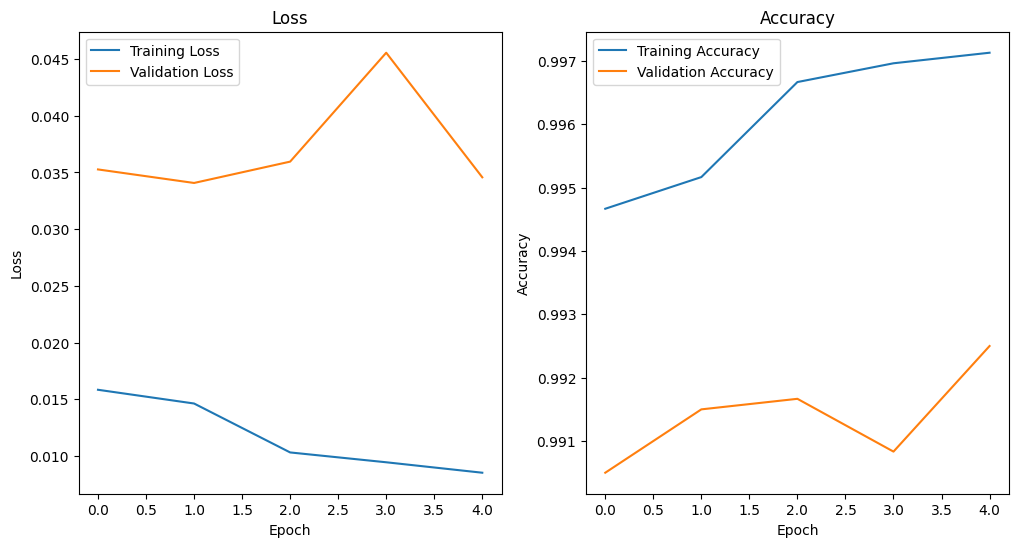

In [12]:
history = hybrid_model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Eğitim ve doğrulama kayıplarını görselleştirme
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Eğitim ve doğrulama doğruluklarını görselleştirme
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [13]:
import pandas as pd

# Tahmin sonuçlarını ve gerçek etiketleri bir DataFrame'e dönüştürme
results_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': predicted_labels
})

# DataFrame'i CSV dosyasına kaydetme
results_df.to_csv('prediction_results.csv', index=False)


In [7]:
# Modeli oluşturun
classical_model = create_classical_model()

# Modeli derleyin ve eğitin
classical_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
classical_model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
1688/1688 [==============================] - 80s 46ms/step - loss: 4.1871 - accuracy: 0.1013 - val_loss: 4.1589 - val_accuracy: 0.0978
Epoch 2/5
1688/1688 [==============================] - 81s 48ms/step - loss: 4.1588 - accuracy: 0.0988 - val_loss: 4.1589 - val_accuracy: 0.0978
Epoch 3/5
1688/1688 [==============================] - 82s 48ms/step - loss: 4.1588 - accuracy: 0.0988 - val_loss: 4.1589 - val_accuracy: 0.0978
Epoch 4/5
1688/1688 [==============================] - 78s 46ms/step - loss: 4.1588 - accuracy: 0.0988 - val_loss: 4.1589 - val_accuracy: 0.0978
Epoch 5/5
1688/1688 [==============================] - 79s 47ms/step - loss: 4.1588 - accuracy: 0.0988 - val_loss: 4.1589 - val_accuracy: 0.0978


In [9]:
# Test verileri ile tahmin yapma
test_predictions_classical = classical_model.predict(x_test)
predicted_labels_classical = np.argmax(test_predictions_classical, axis=1)

# Modelin başarı oranını hesaplama
test_loss_classical, test_acc_classical = classical_model.evaluate(x_test, y_test, verbose=2)
print(f'Classical CNN Test accuracy: {test_acc_classical}')

# İlk birkaç görüntü ve tahmin sonuçlarını görselleştirme
plot_predictions(x_test, y_test, predicted_labels_classical, num_examples=10)


313/313 [==============================] - 4s 14ms/step
313/313 - 4s - loss: 4.1589 - accuracy: 0.0980 - 4s/epoch - 12ms/step
Classical CNN Test accuracy: 0.09799999743700027


NameError: name 'plot_predictions' is not defined